<a href="https://colab.research.google.com/github/aysebren/car_park_detection/blob/master/ModelWithPKandSave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn

In [ ]:
!pip install livelossplot

In [ ]:
from google.colab import drive, files
import keras
import keras.utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras import backend as K

In [ ]:

plot_losses = livelossplot.PlotLossesKeras()

IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64
TEST_SIZE = 30
seed=42
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

model = Sequential()
K.set_learning_phase(1)
np.random.seed(seed)
base_model = ResNet50(weights='imagenet', include_top=False)

# for layer in model.layers[:140]:
#    layer.trainable = False

# for layer in model.layers[140:]:
#    layer.trainable = True


alpha = 0.00002  # weight decay coefficient

for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

initial_lrate=0.01
iteration=200
decay=0.01
lrate = initial_lrate * (1 / (1 + decay * iteration))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)

#x = Dropout(0.7)(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=lrate),
            metrics=['accuracy'])

In [ ]:


#path = "/content/drive/My Drive/CNRPark-Patches-150x150/"
path = "/content/drive/My Drive/pklotmix/"
train_data_dir = path + "train1"
valid_data_dir = path + "validation"


# Data augmentation

training_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


# Validation Data augmentation
valid_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255)

# Validation Data preparation
valid_generator = training_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")




Found 17160 images belonging to 2 classes.
Found 5038 images belonging to 2 classes.


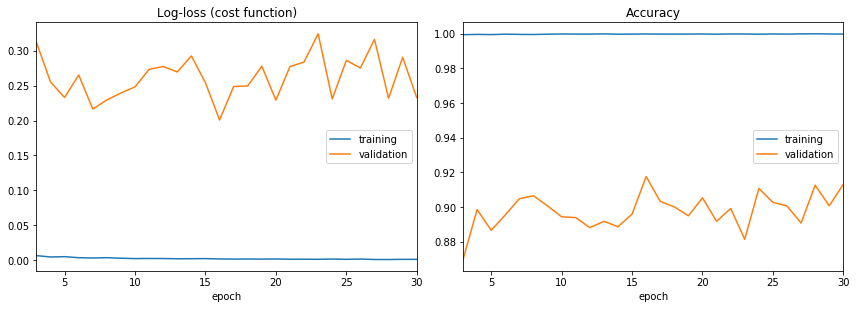

Log-loss (cost function):
training   (min:    0.001, max:    0.050, cur:    0.001)
validation (min:    0.197, max:    0.324, cur:    0.233)

Accuracy:
training   (min:    0.991, max:    1.000, cur:    1.000)
validation (min:    0.870, max:    0.917, cur:    0.913)


In [ ]:
K.set_learning_phase(1)
history = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[plot_losses],
    validation_data = valid_generator,
    validation_steps = 30,
    verbose=1)


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('mymodelpk.h5')
model_file = drive.CreateFile({'title' : 'mymodelpk.h5'})
model_file.SetContentFile('mymodelpk.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
model.save_weights('mymodelpk_weights.h5')
weight_file = drive.CreateFile({'title' : 'mymodelpk_weights.h5'})
weight_file.SetContentFile('mymodelpk_weights.h5')
weight_file.Upload()

# download to google drive
drive.CreateFile({'id': weight_file.get('id')})

In [ ]:
K.set_learning_phase(0)
test_data_dir = "/content/drive/My Drive/pklotmix/test/"
#test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2244 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//8)

print(score[0])
print(score[1])

0.02109833694744988
0.9982142857142857


In [ ]:
test_generator.reset()

In [ ]:
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_learning_phase(0)
#test_data_dir = "/content/drive/My Drive/pklotmix/test/"
test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2518 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//128)

print(score[0])
print(score[1])

0.09297746763025459
0.9736842105263158


In [ ]:
from keras.models import load_model

model=load_model('mymodelpk.h5')

In [ ]:
import os
os.chdir("drive/My Drive")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_path = "2015-12-22_1548.jpg"#"deneme.tif"#"2015-12-22_1548.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [ ]:
from PIL import Image

img = Image.open("deneme.tif").convert('RGB')#("deneme.tif").convert('RGB')#("2015-12-22_1548.jpg").convert('RGB')
#pix = img.load()
cols,rows = img.size


def ndg(img,rows,cols):
   mat = [[0] * rows] * cols#[[0 for i in range(cols)]  for j in range(rows)]

   for i in range(cols):
      for j in range(rows):
          val= img.getpixel((i,j))
          mat[i][j]=val;
         # print(val,',')
         # mat[i][j] = val[2]*0.299+val[1]*0.587+val[0]*0.114
   return mat


asd=ndg(img,rows,cols)
print(np.shape(asd))
plt.imshow(window)
    plt.show()


In [ ]:
def jpg_image_to_array(image_path):
  """
  Loads JPEG image into 3D Numpy array of shape
  (width, height, channels)
  """
  with Image.open(image_path) as image:
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
  return im_arr

In [ ]:


img = image2pixelarray("deneme.tif")#("2015-12-22_1548.jpg").convert('RGB')

In [ ]:
from PIL import Image
import numpy
im = Image.open("deneme.tif")
np_im = numpy.array(im)
print (np_im.shape)


(562, 1000)


In [ ]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
  mat = [[[0] * 3] * 128]*128
  for ar in range(0,rows-129):
    for y in range(0,cols-129):
        for x in range(0,128):
          mat[x]=image[x+y][0+ar:128+ar]

    yield (x,y,mat)
         #box = (x, y, x + windowSize[0], y + windowSize[1])
         #cropped_img = image[box[0]:box[2]][ box[1]:box[3]]
         #print(cropped_img[1:3][1:3])
         #a= np.shape(cropped_img)
         #label= model.predict(cropped_img)
    #return cropped_img

# loop over the image pyramid
(winW, winH) = (128, 128)
#asd=ndg(img,rows,cols)

for (x, y, window) in sliding_window(asd, 8, (winW, winH)):
    #print(a)
    #window = np.expand_dims(window, axis=0)
    plt.imshow(window)
    plt.show()
   # print(np.shape(window))
    #label=model.predict(window)
    #print(label)
#print(ndg(img,rows,cols))

562 1000


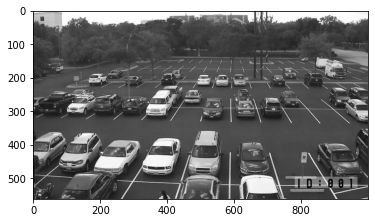

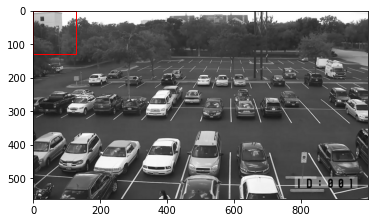

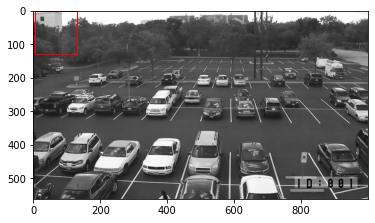

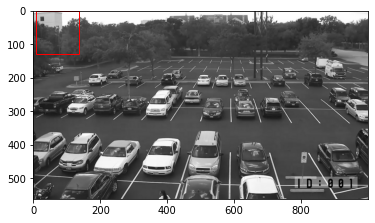

KeyboardInterrupt: ignored

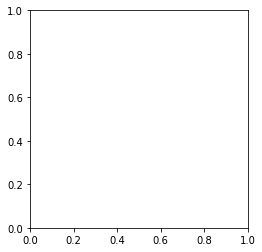

In [ ]:
# import the necessary packages
import cv2
import imutils
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = image.load_img("deneme.tif").convert('RGB')
rows,cols = img.size
px=img.load()


print(cols,rows)

def ndg(img,rows,cols):
    mat =[[0 for i in range(rows)]  for j in range(cols)]

    for i in range(cols):
        for j in range(rows):
            mat[i][j]=0
    for x in range(cols):
        for y in range(rows):
            val= img.getpixel((y,x))
            mat[x][y]=val;

            #mat[x][y] = val[2]*0.299+val[1]*0.587+val[0]*0.114
    return mat

asd= ndg(img,rows,cols)


plt.imshow(asd)
plt.show()
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, cols, stepSize):
		for x in range(0, rows, stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1]][ x:x + windowSize[0]])
# loop over the image pyramid
(winW, winH) = (128, 128)

	# loop over the sliding window for each layer of the pyramid
for (x, y, window) in sliding_window(asd, stepSize=4, windowSize=(winW, winH)):

# Create figure and axes
    fig,ax = plt.subplots(1)

# Display the image
    ax.imshow(asd)

# Create a Rectangle patch
    rect = patches.Rectangle((x,y),winW,winH,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

In [ ]:
import random
import numpy as np
from PIL import Image
WINDOW_SIZES = [i for i in range(20, 160, 20)]


img = image.load_img("deneme.tif").convert('RGB')
rows,cols = img.size
px=img.load()


print(cols,rows)

def ndg(img,rows,cols):
    mat =[[0 for i in range(rows)]  for j in range(cols)]

    for i in range(cols):
        for j in range(rows):
            mat[i][j]=0
    for x in range(cols):
        for y in range(rows):
            val= img.getpixel((y,x))
            #mat[x][y]=val;

            mat[x][y] = val[2]*0.299+val[1]*0.587+val[0]*0.114
    return mat

asd= ndg(img,rows,cols)


def get_best_bounding_box(img, predict_fn, step=10, window_sizes=WINDOW_SIZES):
    best_box = None
    best_box_prob = -np.inf

    # loop window sizes: 20x20, 30x30, 40x40...160x160
    for win_size in window_sizes:
        for top in range(0, cols - win_size + 1, step):
            for left in range(0, rows - win_size + 1, step):
                # compute the (top, left, bottom, right) of the bounding box
                box = (top, left, top + win_size, left + win_size)

                # crop the original image
                cropped_img = img[box[0]:box[2]][ box[1]:box[3]]

                # predict how likely this cropped image is dog and if higher
                # than best save it
                print('predicting for box %r' % (box, ))
                box_prob = predict_fn(cropped_img)
                if box_prob > best_box_prob:
                    best_box = box
                    best_box_prob = box_prob

    return best_box


def predict_function(x):
    # example of prediction function for simplicity, you
    # should probably use `return model.predict(x)`
    random.seed(x[0])
    return random.random()


# dummy array of 256X256
#img = np.arange(256 * 256*3).reshape((256, 256,3))

#img = Image.open("deneme.tif")#("2015-12-22_1548.jpg").convert('RGB')
#cols,rows = img.size
best_box = get_best_bounding_box(asd, predict_function)
print('best bounding box %r' % (best_box, ))

562 1000
predicting for box (0, 0, 20, 20)


TypeError: ignored

In [ ]:
--NotebookApp.iopub_data_rate_limit=10000000000000

SyntaxError: ignored

In [ ]:
--generate-config

NameError: ignored